In [1]:
from pathlib import Path
import json
from time import sleep
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import torch
from torch import distributions

In [3]:
from envs import make_env
from modules import BackpropamineAgent
from utils import NumpyTube

In [4]:
exp_path = Path("./artifacts/MiconiMaze-027edb82a64c44a4a6256579729ed953")

In [5]:
with open(exp_path / "config.json") as f:
    config = json.loads(f.read())

In [6]:
config

{'artifact_path': './artifacts',
 'batch_size': 16,
 'checkpoint_interval': 1000,
 'entropy_coef': 0.03,
 'env_id': 'MiconiMaze',
 'feature_size': 64,
 'gamma': 0.9,
 'hidden_size': 128,
 'lam': 1.0,
 'lifetime_length': 200,
 'log_interval': 100,
 'lr': 0.0001,
 'lr_decay_gamma': 0.5,
 'lr_decay_step_size': 10000,
 'max_grad_norm': 4.0,
 'num_lifetimes': 40000,
 'recurrent': True,
 'seed': 0,
 'update_best_interval': 100,
 'value_coef': 0.1}

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
env = make_env(config["env_id"], config["batch_size"], seed=0)

In [9]:
agent = BackpropamineAgent(
    env.obs_shape,
    feature_size=config["feature_size"],
    hidden_size=config["hidden_size"],
    action_size=env.action_size,
).eval().to(device)

In [10]:
state_dict = torch.load(exp_path / "model_final.pth")
agent.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
nptube = NumpyTube()

rewards = []
mod_signals = []
hebbs = []

obs = env.reset().to(device)
h = hebb = None
prev_action = torch.zeros(config["batch_size"], env.action_size).to(device)
prev_reward = torch.zeros(config["batch_size"], 1).to(device)

for i in range(400):
    nptube.imshow(env.render())
    
    rewards.append(prev_reward)
    
    with torch.no_grad():
        action_probs, value_pred, m, h, hebb = agent(obs, prev_action, prev_reward, h, hebb)
    pi = distributions.OneHotCategorical(probs=action_probs)
    action_one_hot = pi.sample()
    action = torch.argmax(action_one_hot, dim=1).cpu()

    obs, reward = env.step(action)
    obs = obs.to(device)
    reward = reward.to(device)

    prev_action = action_one_hot
    prev_reward = reward
    
    mod_signals.append(m.cpu().numpy())
    hebbs.append(hebb.cpu().numpy())

    sleep(5e-2)

nptube.close()

In [12]:
hebbs = np.stack(hebbs)
hebb_norm = np.mean(np.abs(hebbs), axis=(2, 3))
hebb_delta = np.abs(hebbs[1:] - hebbs[:-1])
hebb_delta = np.mean(hebb_delta, axis=(2, 3))

Comparing neuromodulator outputs, weight changes in the Hebbian traces, and rewards:

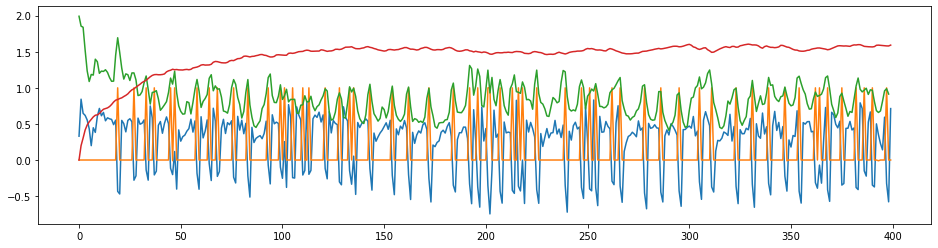

In [13]:
plt.figure(figsize=(16, 4))
plt.plot([m[0] for m in mod_signals])
plt.plot([r[0] / 10 for r in rewards])
plt.plot(hebb_delta[:, 0] * 10)  # multiply by 10 for better visualization
plt.plot(hebb_norm[:, 0])
plt.show()

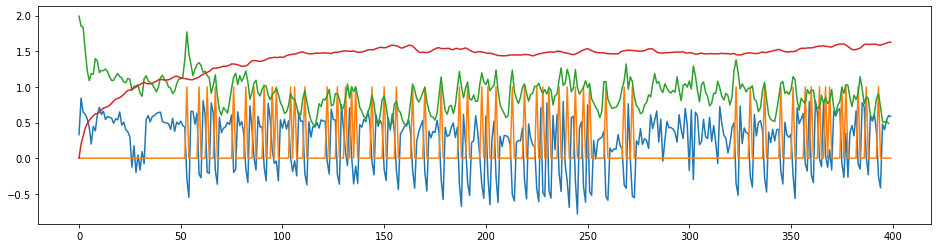

In [14]:
plt.figure(figsize=(16, 4))
plt.plot([m[1] for m in mod_signals])
plt.plot([r[1] / 10 for r in rewards])
plt.plot(hebb_delta[:, 1] * 10)  # multiply by 10 for better visualization
plt.plot(hebb_norm[:, 1])
plt.show()

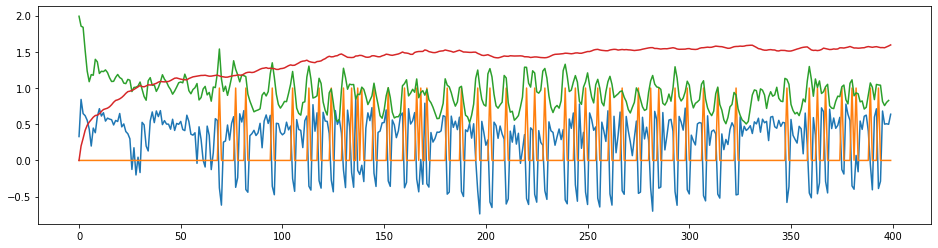

In [15]:
plt.figure(figsize=(16, 4))
plt.plot([m[2] for m in mod_signals])
plt.plot([r[2] / 10 for r in rewards])
plt.plot(hebb_delta[:, 2] * 10)  # multiply by 10 for better visualization
plt.plot(hebb_norm[:, 2])
plt.show()

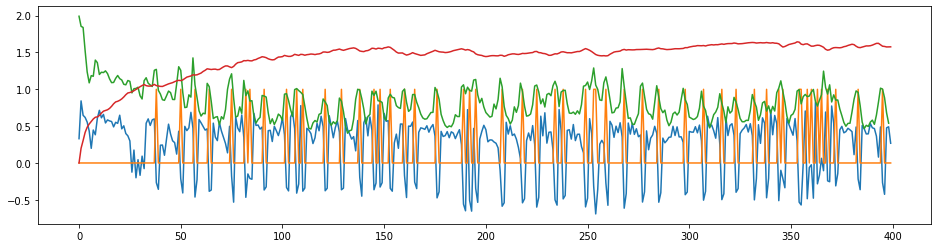

In [16]:
plt.figure(figsize=(16, 4))
plt.plot([m[3] for m in mod_signals])
plt.plot([r[3] / 10 for r in rewards])
plt.plot(hebb_delta[:, 3] * 10)  # multiply by 10 for better visualization
plt.plot(hebb_norm[:, 3])
plt.show()

There's a pretty clear pattern in how the agent reacts to reward signals -- each spike is where the agent is teleported to a random position (immediately after it receives a reward), and the modulator sends a negative signal, triggering the Hebbian trace to make large changes.